# Data Exploration
Objective: Explore how betting lines are distributed


In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import re
from pathlib import Path
from scipy.stats import normaltest

import glob
import seaborn as sns
import matplotlib.pyplot as plt
import json


cwd = os.getcwd()

# Add directories for modules and data files
dirs = [x[0] for x in os.walk(cwd)]
[sys.path.append(d) for d in dirs]
data_dir = cwd+'\\Input\\DataFiles\\' # Manual way; TODO: find a relative way to do this automatically
vegas_dir = cwd+'\\Input\\VegasOdds\\'

import elo


In [2]:
p = Path('.')
paths = list(p.glob('**/*.csv'))
paths

[WindowsPath('merged.csv'),
 WindowsPath('odds_2017_basic.csv'),
 WindowsPath('Input/DataFiles/Cities.csv'),
 WindowsPath('Input/DataFiles/ConferenceTourneyGames.csv'),
 WindowsPath('Input/DataFiles/EloHistory.csv'),
 WindowsPath('Input/DataFiles/GameCities.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyDetailedResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyDetailedResultsEnriched.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySeeds.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySlots.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonCompactResults.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonDetailedResults.csv'),
 WindowsPath('Input/DataFiles/SeasonElos.csv'),
 WindowsPath('Input/DataFiles/SeasonElosK25.csv'),
 WindowsPath('Input/DataFiles/Seasons.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyTeams.csv'),
 WindowsPath('Input/DataFi

In [3]:
teams = pd.read_csv(data_dir+'Teams.csv')
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [4]:
team_spellings = pd.read_csv(data_dir+'TeamSpellings.csv')
team_spellings.sort_values('TeamID')
team_spelling_dict = dict(zip(team_spellings.TeamNameSpelling, team_spellings.TeamID))

In [5]:
start = 2003
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season>=start]
rs_c = rs_c.drop(['NumOT'], axis=1)
rs_c = rs_c.reset_index(drop=True)
rs_c.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
82036,2018,132,1153,56,1222,55,N
82037,2018,132,1172,58,1348,57,N
82038,2018,132,1209,74,1426,61,N
82039,2018,132,1246,77,1397,72,N
82040,2018,132,1335,68,1217,65,N


In [6]:
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr = tourney_cr.reset_index(drop=True)
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
1043,2018,146,1437,71,1403,59,12
1044,2018,146,1242,85,1181,81,4
1045,2018,152,1276,69,1260,57,12
1046,2018,152,1437,95,1242,79,16
1047,2018,154,1437,79,1276,62,17


In [7]:
def get_seed(seed):
    #Get just the digits from the seeding. Return as int
    s_int = seed[1:3]
    return int(s_int)

df_seeds = pd.read_csv(data_dir+'NCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds.Season >= start]
df_seeds['Seed'] = df_seeds.Seed.apply(get_seed)
df_stats = df_seeds.copy().reset_index().drop('index', axis=1)
df_stats.head()

,Season,Seed,TeamID
0,2003,1,1328
1,2003,2,1448
2,2003,3,1393
3,2003,4,1257
4,2003,5,1280


## Cleaning Odds DataFrames

### Step 1: Assign Team Name to Team ID

In [8]:
def assign_team(team_string, team_spelling_dict=team_spelling_dict):
    '''
    Given a string of the team's name (team_string), return its TeamID from the dictionary of Team ID's and spellings
    '''
    team_string = team_string.lower()
    try:
        return team_spelling_dict[team_string]
    except KeyError:
        # Modify string if team_string initially isn't found
        try:
            team_string = team_string.replace(' ', '-')
            return team_spelling_dict[team_string]

        except KeyError:
            print("NOT FOUND:", team_string)
            return np.NaN
        
odds_2017 = pd.read_csv(vegas_dir+'ncaabb17.csv')

# Assign Team ID to Home/Road team
odds_2017['homeID'] = list(map(assign_team, odds_2017.home))
odds_2017['roadID'] = list(map(assign_team, odds_2017.road))

# Convert date to datetime
odds_2017.date = pd.to_datetime(odds_2017.date)
odds_2017 = odds_2017.sort_values('date').reset_index(drop=True).sort_index()

# Initial odds dataframe
print("INITIAL SHAPE")
print(odds_2017.shape)

# Drop teams that can't be found
odds_2017.dropna(subset=['homeID','roadID'], inplace=True)
odds_2017[['homeID', 'roadID']] = odds_2017[['homeID', 'roadID']].astype(int)
print("SHAPE AFTER DROPPING UNKNOWN SCHOOLS")
print(odds_2017.shape)
odds_2017.tail()

NOT FOUND: nj-tech
NOT FOUND: concordia-st.-paul
NOT FOUND: ut-rio-grande-valley
NOT FOUND: ut-rio-grande-valley
INITIAL SHAPE
(4078, 33)
SHAPE AFTER DROPPING UNKNOWN SCHOOLS
(4074, 33)


,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linepib,line7ot,lineer,linedd,linemassey,linedunk,lineround,lineteamrnks,homeID,roadID
4073,2018-03-30,North Texas,88.0,San Francisco,77.0,4.5,2.63,1.49,10.89,1.53,...,NaN,-1.0,NaN,-6.68,5.27,-1.59,NaN,2.3,1317,1362
4074,2018-03-30,Northern Colorado,76.0,Illinois-Chicago,71.0,9.5,7.11,6.63,3.76,6.92,...,NaN,5.0,NaN,2.55,7.81,7.68,NaN,7.5,1294,1227
4075,2018-03-31,Michigan,69.0,Loyola-Chicago,57.0,5.5,6.59,7.59,0.78,7.65,...,NaN,2.0,NaN,2.79,6.05,8.99,NaN,7.1,1276,1260
4076,2018-03-31,Villanova,95.0,Kansas,79.0,5.0,4.60,3.72,3.99,3.67,...,NaN,2.0,NaN,1.11,6.03,6.06,NaN,4.6,1437,1242
4077,2018-04-02,Villanova,79.0,Michigan,62.0,6.5,4.79,6.19,-2.12,6.44,...,NaN,NaN,NaN,-2.34,5.35,2.97,NaN,7.0,1437,1276


### Step 2: Assign Winning and Losing Team ID's

In [9]:
# Assign Winner / Loser Team ID's
odds_2017['WTeamID'] = (odds_2017[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] > x[1]) else x[3], axis=1))
odds_2017['LTeamID'] = (odds_2017[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] < x[1]) else x[3], axis=1))
odds_2017[['hscore', 'rscore', 'homeID', 'roadID', 'WTeamID', 'LTeamID']]

,hscore,rscore,homeID,roadID,WTeamID,LTeamID
0,101.0,67.0,1112,1319,1112.0,1319.0
1,57.0,54.0,1330,1406,1330.0,1406.0
2,99.0,82.0,1333,1381,1333.0,1381.0
3,105.0,74.0,1345,1188,1345.0,1188.0
4,72.0,73.0,1349,1184,1184.0,1349.0
5,63.0,76.0,1350,1174,1174.0,1350.0
6,71.0,83.0,1362,1253,1253.0,1362.0
7,90.0,68.0,1371,1192,1371.0,1192.0
8,65.0,54.0,1355,1414,1355.0,1414.0
9,60.0,59.0,1378,1194,1378.0,1194.0


### Step 3: Drop Line Columns With Many NaNs

In [10]:
odds_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 0 to 4077
Data columns (total 35 columns):
date            4074 non-null datetime64[ns]
home            4074 non-null object
hscore          4066 non-null float64
road            4074 non-null object
rscore          4070 non-null float64
line            4055 non-null float64
lineavg         4074 non-null float64
linesag         4062 non-null float64
linesage        4062 non-null float64
linesagp        4062 non-null float64
linesaggm       4062 non-null float64
linemoore       4062 non-null float64
lineopen        4051 non-null float64
linedok         4067 non-null float64
linefox         4050 non-null float64
std             4074 non-null float64
linepugh        3991 non-null float64
linedonc        3958 non-null float64
neutral         4062 non-null float64
linetalis       3865 non-null float64
lineespn        3941 non-null float64
linepir         771 non-null float64
linepiw         0 non-null float64
linepib         0 

In [11]:
def drop_mostly_nans(df, cols, thresh=0.1):
    '''
    Drop columns (cols) from a dataframe (df) that have a percentage of nans > threshold
    Returns new df with dropped columns
    '''
    n = len(df)
    for col in cols:
        nans = df[col].isnull().sum()
        if (nans / n) > thresh:
            df.drop(col, axis=1, inplace=True)
            print("Dropping ", col)
            
    return df

# Drop columns with >10% null values
line_cols = [col for col in odds_2017 if col.startswith('line')]
odds_2017 = drop_mostly_nans(odds_2017, line_cols)
line_cols = [col for col in odds_2017 if col.startswith('line')]
odds_2017.info()

Dropping  linepir
Dropping  linepiw
Dropping  linepib
Dropping  linedd
Dropping  linedunk
Dropping  lineround
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 0 to 4077
Data columns (total 29 columns):
date            4074 non-null datetime64[ns]
home            4074 non-null object
hscore          4066 non-null float64
road            4074 non-null object
rscore          4070 non-null float64
line            4055 non-null float64
lineavg         4074 non-null float64
linesag         4062 non-null float64
linesage        4062 non-null float64
linesagp        4062 non-null float64
linesaggm       4062 non-null float64
linemoore       4062 non-null float64
lineopen        4051 non-null float64
linedok         4067 non-null float64
linefox         4050 non-null float64
std             4074 non-null float64
linepugh        3991 non-null float64
linedonc        3958 non-null float64
neutral         4062 non-null float64
linetalis       3865 non-null float64
lineespn        39

### Step 4: Of The Missing Remaining Line Columns With Missing Values, Replace NaN's with Mean Line (lineavg)

In [12]:
### Replace NaN line values with the average line (lineavg column)

def replace_na(df, na_cols, replace_with):
    series_replacement = df[replace_with]
    for col in na_cols:
        df[col] = df[col].fillna(series_replacement)
    return df

odds_2017 = replace_na(df=odds_2017, na_cols=line_cols, replace_with='lineavg')
odds_2017['margin'] = odds_2017.hscore - odds_2017.rscore
odds_2017 = odds_2017.dropna(axis=0,how='any', subset=['margin'])
odds_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4066 entries, 0 to 4077
Data columns (total 30 columns):
date            4066 non-null datetime64[ns]
home            4066 non-null object
hscore          4066 non-null float64
road            4066 non-null object
rscore          4066 non-null float64
line            4066 non-null float64
lineavg         4066 non-null float64
linesag         4066 non-null float64
linesage        4066 non-null float64
linesagp        4066 non-null float64
linesaggm       4066 non-null float64
linemoore       4066 non-null float64
lineopen        4066 non-null float64
linedok         4066 non-null float64
linefox         4066 non-null float64
std             4066 non-null float64
linepugh        4066 non-null float64
linedonc        4066 non-null float64
neutral         4059 non-null float64
linetalis       4066 non-null float64
lineespn        4066 non-null float64
line7ot         4066 non-null float64
lineer          4066 non-null float64
linemassey    

### Step 5: Round Remaining Lines To The Nearest 0.5

In [13]:
# def round_pt5(number):
#     """
#     Round a number to the closest half integer.
#     """
#     round(number)
#     return round(number * 2) / 2

# # Round line to nearest 0.5
# odds_2017[line_cols] = odds_2017[line_cols].applymap(round_pt5)
odds_2017.tail()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,lineespn,line7ot,lineer,linemassey,lineteamrnks,homeID,roadID,WTeamID,LTeamID,margin
4073,2018-03-30,North Texas,88.0,San Francisco,77.0,4.5,2.63,1.49,10.89,1.53,...,5.37,-1.00,2.63,5.27,2.3,1317,1362,1317.0,1362.0,11.0
4074,2018-03-30,Northern Colorado,76.0,Illinois-Chicago,71.0,9.5,7.11,6.63,3.76,6.92,...,12.44,5.00,7.11,7.81,7.5,1294,1227,1294.0,1227.0,5.0
4075,2018-03-31,Michigan,69.0,Loyola-Chicago,57.0,5.5,6.59,7.59,0.78,7.65,...,5.94,2.00,6.59,6.05,7.1,1276,1260,1276.0,1260.0,12.0
4076,2018-03-31,Villanova,95.0,Kansas,79.0,5.0,4.60,3.72,3.99,3.67,...,6.36,2.00,4.60,6.03,4.6,1437,1242,1437.0,1242.0,16.0
4077,2018-04-02,Villanova,79.0,Michigan,62.0,6.5,4.79,6.19,-2.12,6.44,...,8.51,4.79,4.79,5.35,7.0,1437,1276,1437.0,1276.0,17.0


In [14]:
odds_2017.tail()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,lineespn,line7ot,lineer,linemassey,lineteamrnks,homeID,roadID,WTeamID,LTeamID,margin
4073,2018-03-30,North Texas,88.0,San Francisco,77.0,4.5,2.63,1.49,10.89,1.53,...,5.37,-1.00,2.63,5.27,2.3,1317,1362,1317.0,1362.0,11.0
4074,2018-03-30,Northern Colorado,76.0,Illinois-Chicago,71.0,9.5,7.11,6.63,3.76,6.92,...,12.44,5.00,7.11,7.81,7.5,1294,1227,1294.0,1227.0,5.0
4075,2018-03-31,Michigan,69.0,Loyola-Chicago,57.0,5.5,6.59,7.59,0.78,7.65,...,5.94,2.00,6.59,6.05,7.1,1276,1260,1276.0,1260.0,12.0
4076,2018-03-31,Villanova,95.0,Kansas,79.0,5.0,4.60,3.72,3.99,3.67,...,6.36,2.00,4.60,6.03,4.6,1437,1242,1437.0,1242.0,16.0
4077,2018-04-02,Villanova,79.0,Michigan,62.0,6.5,4.79,6.19,-2.12,6.44,...,8.51,4.79,4.79,5.35,7.0,1437,1276,1437.0,1276.0,17.0


In [15]:
tourney_2018 = tourney_cr.loc[tourney_cr.Season == 2018]
tourney_2018.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
981,2018,134,1347,71,1254,61,10
982,2018,134,1382,65,1417,58,7
983,2018,135,1411,64,1300,46,18
984,2018,135,1393,60,1113,56,4
985,2018,136,1348,83,1328,78,5


In [16]:
tourney_teams_by_season = dict(df_seeds.groupby('Season')['TeamID'].unique())
tourney_teams_by_season

{2003: array([1328, 1448, 1393, 1257, 1280, 1329, 1386, 1143, 1301, 1120, 1335,
        1139, 1122, 1264, 1190, 1354, 1400, 1196, 1462, 1390, 1163, 1268,
        1277, 1261, 1345, 1160, 1423, 1140, 1360, 1407, 1358, 1411, 1421,
        1246, 1338, 1266, 1173, 1458, 1281, 1231, 1332, 1428, 1104, 1356,
        1451, 1409, 1221, 1447, 1237, 1112, 1242, 1181, 1228, 1323, 1166,
        1272, 1153, 1211, 1113, 1141, 1454, 1443, 1161, 1429, 1436], dtype=int64),
 2004: array([1181, 1280, 1400, 1153, 1228, 1314, 1462, 1371, 1112, 1257, 1102,
        1293, 1190, 1343, 1284, 1106, 1390, 1163, 1301, 1268, 1393, 1435,
        1177, 1104, 1356, 1173, 1444, 1140, 1431, 1418, 1436, 1427, 1386,
        1329, 1338, 1448, 1196, 1458, 1272, 1403, 1150, 1376, 1350, 1264,
        1433, 1416, 1186, 1251, 1246, 1211, 1210, 1242, 1344, 1130, 1277,
        1449, 1412, 1305, 1428, 1334, 1227, 1320, 1434, 1197, 1250], dtype=int64),
 2005: array([1449, 1448, 1211, 1257, 1210, 1403, 1452, 1334, 1338, 1166, 1417,
  

In [17]:
### Create a special subset of odds for NCAA tournament games

odds_tourney_2018 = (odds_2017.loc[
    (odds_2017.date > '2018-03-12') & 
    (odds_2017.homeID.isin(tourney_teams_by_season[2018]) |
    odds_2017.roadID.isin(tourney_teams_by_season[2018]))
]
)
odds_tourney_2018.head()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,lineespn,line7ot,lineer,linemassey,lineteamrnks,homeID,roadID,WTeamID,LTeamID,margin
3950,2018-03-13,UCLA,58.0,St. Bonaventure,65.0,3.0,2.84,2.66,3.96,2.68,...,-0.21,4.0,2.84,2.72,2.4,1417,1382,1382.0,1417.0,-7.0
3952,2018-03-13,Radford,71.0,LIU Brooklyn,61.0,6.0,5.25,4.33,4.27,4.38,...,5.83,6.0,5.25,5.18,4.4,1347,1254,1347.0,1254.0,10.0
3961,2018-03-14,Texas Southern,64.0,NC Central,46.0,5.5,3.17,3.30,-1.49,3.88,...,2.52,-1.0,3.17,4.79,3.3,1411,1300,1411.0,1300.0,18.0
3964,2018-03-14,Syracuse,60.0,Arizona St.,56.0,-2.0,1.03,-0.07,5.87,-0.95,...,0.69,-2.0,1.03,1.00,-1.1,1393,1113,1393.0,1113.0,4.0
3979,2018-03-15,Ohio St.,81.0,South Dakota St.,73.0,8.0,6.56,7.28,-6.41,8.17,...,9.01,4.0,6.56,6.15,7.9,1326,1355,1326.0,1355.0,8.0


In [18]:
odds_tourney_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 3950 to 4077
Data columns (total 30 columns):
date            67 non-null datetime64[ns]
home            67 non-null object
hscore          67 non-null float64
road            67 non-null object
rscore          67 non-null float64
line            67 non-null float64
lineavg         67 non-null float64
linesag         67 non-null float64
linesage        67 non-null float64
linesagp        67 non-null float64
linesaggm       67 non-null float64
linemoore       67 non-null float64
lineopen        67 non-null float64
linedok         67 non-null float64
linefox         67 non-null float64
std             67 non-null float64
linepugh        67 non-null float64
linedonc        67 non-null float64
neutral         67 non-null float64
linetalis       67 non-null float64
lineespn        67 non-null float64
line7ot         67 non-null float64
lineer          67 non-null float64
linemassey      67 non-null float64
lineteamrnks    67 non-

### BONUS: Do this all in a module: oddscleaner

In [19]:
import oddscleaner

In [20]:
odds_2016 = pd.read_csv(vegas_dir+'ncaabb16.csv')
odds_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 31 columns):
date            4013 non-null object
home            4013 non-null object
hscore          3974 non-null float64
road            4013 non-null object
rscore          3999 non-null float64
line            3993 non-null float64
lineavg         4012 non-null float64
linesag         3988 non-null float64
linesage        3988 non-null float64
linesagp        3988 non-null float64
linesaggm       3988 non-null float64
linemoore       3988 non-null float64
lineopen        3972 non-null float64
linedok         3996 non-null float64
linefox         3988 non-null float64
std             4012 non-null float64
linepugh        3987 non-null float64
linedonc        3953 non-null float64
neutral         3989 non-null float64
lineashby       0 non-null float64
lineespn        3921 non-null float64
linepir         342 non-null float64
linepiw         342 non-null float64
linepib         342 non-nul

In [21]:
odds_2016['homeID'] = list(map(assign_team, odds_2016.home))
odds_2016['roadID'] = list(map(assign_team, odds_2016.road))
odds_2016['WTeamID'] = (odds_2016[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] > x[1]) else x[3], axis=1)
                       )
odds_2016['LTeamID'] = (odds_2016[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] < x[1]) else x[3], axis=1)
                       )
odds_2016[['hscore', 'rscore', 'homeID', 'roadID', 'WTeamID', 'LTeamID']].head()

NOT FOUND: ut-rio-grande-valley
NOT FOUND: st.-peter''s


,hscore,rscore,homeID,roadID,WTeamID,LTeamID
0,70.0,53.0,1104,1157.0,1104.0,1157.0
1,65.0,63.0,1112,1277.0,1112.0,1277.0
2,88.0,70.0,1113,1340.0,1113.0,1340.0
3,92.0,83.0,1116,1236.0,1116.0,1236.0
4,76.0,61.0,1124,1331.0,1124.0,1331.0


In [22]:
# Do the same thing with oddscleaner module
odds_2016 = oddscleaner.clean_lines(odds_2016)
odds_2016.info()

Dropping  lineashby
Dropping  linepir
Dropping  linepiw
Dropping  linepib
Dropping  line7ot
Dropping  lineer
Dropping  linedd
Dropping  linedunk
Dropping  lineround
Dropping  lineteamrnks
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3973 entries, 0 to 3973
Data columns (total 26 columns):
date          3973 non-null datetime64[ns]
home          3973 non-null object
hscore        3973 non-null float64
road          3973 non-null object
rscore        3973 non-null float64
line          3973 non-null float64
lineavg       3973 non-null float64
linesag       3973 non-null float64
linesage      3973 non-null float64
linesagp      3973 non-null float64
linesaggm     3973 non-null float64
linemoore     3973 non-null float64
lineopen      3973 non-null float64
linedok       3973 non-null float64
linefox       3973 non-null float64
std           3973 non-null float64
linepugh      3973 non-null float64
linedonc      3973 non-null float64
neutral       3961 non-null float64
lineespn      39

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [23]:
odds_2016.tail()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linepugh,linedonc,neutral,lineespn,linemassey,homeID,roadID,WTeamID,LTeamID,margin
3969,2017-03-31,Texas A&M Corpus,61.0,St. Peter's,62.0,-4.0,-1.42,-1.03,0.05,-1.56,...,-4.09,0.1,0.0,-2.85,1.65,1394,1389.0,1389.0,1394.0,-1.0
3970,2017-03-31,Wyoming,83.0,Coastal Carolina,59.0,8.0,6.89,7.22,6.24,7.65,...,4.67,6.2,0.0,9.36,7.55,1461,1157.0,1461.0,1157.0,24.0
3971,2017-04-01,North Carolina,77.0,Oregon,76.0,4.5,2.36,2.97,1.57,3.45,...,2.53,0.4,1.0,1.78,0.11,1314,1332.0,1314.0,1332.0,1.0
3972,2017-04-01,Gonzaga,77.0,South Carolina,73.0,6.5,9.29,8.29,8.34,8.22,...,7.20,9.0,1.0,13.49,8.03,1211,1376.0,1211.0,1376.0,4.0
3973,2017-04-03,Gonzaga,65.0,North Carolina,71.0,-1.0,2.26,1.36,2.32,1.07,...,2.15,2.2,1.0,2.26,4.50,1211,1314.0,1314.0,1211.0,-6.0


In [24]:
odds_tourney_2017 = (odds_2016.loc[
    (odds_2016.date > '2017-03-13') & 
    (odds_2016.homeID.isin(tourney_teams_by_season[2017]) |
    odds_2016.roadID.isin(tourney_teams_by_season[2017]))
]
)
odds_tourney_2017.head()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linepugh,linedonc,neutral,lineespn,linemassey,homeID,roadID,WTeamID,LTeamID,margin
3842,2017-03-14,New Orleans,66.0,Mount St. Marys,67.0,0.0,0.95,0.61,1.57,0.34,...,1.92,3.5,1.0,-1.23,3.15,1309,1291.0,1291.0,1309.0,-1.0
3845,2017-03-14,Wake Forest,88.0,Kansas St.,95.0,-1.5,0.09,-0.28,-0.05,-0.24,...,0.23,-0.4,1.0,1.65,-2.13,1448,1243.0,1243.0,1448.0,-7.0
3853,2017-03-15,UC Davis,67.0,NC Central,63.0,-3.0,-2.33,-1.63,-1.01,-2.03,...,-3.34,-1.8,1.0,-5.51,-1.58,1413,1300.0,1413.0,1300.0,4.0
3858,2017-03-15,Providence,71.0,USC,75.0,-2.5,0.44,-0.26,-0.57,-0.05,...,-0.17,-1.4,1.0,2.21,0.06,1344,1425.0,1425.0,1344.0,-4.0
3872,2017-03-16,Purdue,80.0,Vermont,70.0,9.0,8.87,11.44,9.86,11.92,...,12.65,7.8,1.0,10.22,7.80,1345,1436.0,1345.0,1436.0,10.0


In [25]:
odds_tourney_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 3842 to 3973
Data columns (total 26 columns):
date          67 non-null datetime64[ns]
home          67 non-null object
hscore        67 non-null float64
road          67 non-null object
rscore        67 non-null float64
line          67 non-null float64
lineavg       67 non-null float64
linesag       67 non-null float64
linesage      67 non-null float64
linesagp      67 non-null float64
linesaggm     67 non-null float64
linemoore     67 non-null float64
lineopen      67 non-null float64
linedok       67 non-null float64
linefox       67 non-null float64
std           67 non-null float64
linepugh      67 non-null float64
linedonc      67 non-null float64
neutral       67 non-null float64
lineespn      67 non-null float64
linemassey    67 non-null float64
homeID        67 non-null int64
roadID        67 non-null float64
WTeamID       67 non-null float64
LTeamID       67 non-null float64
margin        67 non-null float64
dtype

### Combining the Tourney Odds from the 2017-2018 tournaments

In [26]:
odds_tourney = pd.concat([odds_tourney_2017, odds_tourney_2018]).reset_index(drop=True).sort_values('date')
odds_tourney = oddscleaner.clean_lines(odds_tourney)
odds_tourney.info()

Dropping  line7ot
Dropping  lineer
Dropping  linetalis
Dropping  lineteamrnks
<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 26 columns):
LTeamID       134 non-null float64
WTeamID       134 non-null float64
date          134 non-null datetime64[ns]
home          134 non-null object
homeID        134 non-null int64
hscore        134 non-null float64
line          134 non-null float64
lineavg       134 non-null float64
linedok       134 non-null float64
linedonc      134 non-null float64
lineespn      134 non-null float64
linefox       134 non-null float64
linemassey    134 non-null float64
linemoore     134 non-null float64
lineopen      134 non-null float64
linepugh      134 non-null float64
linesag       134 non-null float64
linesage      134 non-null float64
linesaggm     134 non-null float64
linesagp      134 non-null float64
margin        134 non-null float64
neutral       134 non-null float64
road          134 non-null object
roadID   

### Combining Odds for the 2016-2017 and 2017-2018 seasons

In [27]:
odds = pd.concat([odds_2017, odds_2016])
odds = oddscleaner.clean_lines(odds)
odds = odds.dropna(subset=['margin'])
odds.info()

Dropping  line7ot
Dropping  lineer
Dropping  linetalis
Dropping  lineteamrnks
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8039 entries, 0 to 8038
Data columns (total 26 columns):
LTeamID       8038 non-null float64
WTeamID       8039 non-null float64
date          8039 non-null datetime64[ns]
home          8039 non-null object
homeID        8039 non-null int64
hscore        8039 non-null float64
line          8039 non-null float64
lineavg       8039 non-null float64
linedok       8039 non-null float64
linedonc      8039 non-null float64
lineespn      8039 non-null float64
linefox       8039 non-null float64
linemassey    8039 non-null float64
linemoore     8039 non-null float64
lineopen      8039 non-null float64
linepugh      8039 non-null float64
linesag       8039 non-null float64
linesage      8039 non-null float64
linesaggm     8039 non-null float64
linesagp      8039 non-null float64
margin        8039 non-null float64
neutral       8020 non-null float64
road          8039 

In [28]:
odds = odds.sort_values('date').reset_index(drop=True).sort_index()
odds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8039 entries, 0 to 8038
Data columns (total 26 columns):
LTeamID       8038 non-null float64
WTeamID       8039 non-null float64
date          8039 non-null datetime64[ns]
home          8039 non-null object
homeID        8039 non-null int64
hscore        8039 non-null float64
line          8039 non-null float64
lineavg       8039 non-null float64
linedok       8039 non-null float64
linedonc      8039 non-null float64
lineespn      8039 non-null float64
linefox       8039 non-null float64
linemassey    8039 non-null float64
linemoore     8039 non-null float64
lineopen      8039 non-null float64
linepugh      8039 non-null float64
linesag       8039 non-null float64
linesage      8039 non-null float64
linesaggm     8039 non-null float64
linesagp      8039 non-null float64
margin        8039 non-null float64
neutral       8020 non-null float64
road          8039 non-null object
roadID        8038 non-null float64
rscore        8039 non-nul

## Exploration: Looking at Odds Distribution for the 2017-2018 season

### First: Add some useful categorical columns:
- "favwins": 1 if favorite (Team with a positive line) wins
- "homewins": 1 if home team wins
- "favorite/underdogID": Team ID of the team who's favored/not favored.
- "againstspread": 1 if the favorite beats the spread, i.e. beats the underdog by more than the line, -1 otherwise.
- "coverspread": 1 if the favorite covers the spread, i.e. the underdog either wins or only loses by less than the line set

In [29]:
odds_2017['favwins'] = (odds_2017[['lineavg', 'margin']]
                        .apply(lambda x: 1 if (x[1] > 0.0) & (x[0] > 0.0) else 0, axis=1)
                       )
odds_2017.favwins = odds_2017.favwins.astype('category')
odds_2017['homewins'] = list(map(lambda x: 1 if x > 0.0 else 0, odds_2017.margin.values))
odds_2017.homewins = odds_2017.homewins.astype('category')
odds_2017['favoriteID'] = (odds_2017[['lineavg', 'margin', 'homeID', 'roadID']]
                           .apply(lambda x: x[2] if (x[1] > 0.0) & (x[0] > 0.0) else x[3], axis=1)
                          )
odds_2017['underdogID'] = (odds_2017[['lineavg', 'margin', 'homeID', 'roadID']]
                           .apply(lambda x: x[3] if (x[1] > 0.0) & (x[0] > 0.0) else x[2], axis=1)
                          )
odds_2017['WinATS'] = (odds_2017[['lineavg', 'margin']]
                                .apply(lambda x: 1 if x[1] > x[0] else -1, axis=1)
                               )
odds_2017['LoseATS'] = -odds_2017['WinATS']
odds_2017.tail(10)

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,roadID,WTeamID,LTeamID,margin,favwins,homewins,favoriteID,underdogID,WinATS,LoseATS
4068,2018-03-27,Utah,69.0,Western Kentucky,64.0,-1.5,-0.42,1.65,-3.63,1.64,...,1443,1428.0,1443.0,5.0,0,1,1443.0,1428.0,1,-1
4069,2018-03-28,Liberty,51.0,Illinois-Chicago,67.0,5.0,5.29,3.96,14.21,3.68,...,1227,1227.0,1251.0,-16.0,0,0,1227.0,1251.0,-1,1
4070,2018-03-28,North Texas,69.0,San Francisco,55.0,3.0,0.40,0.49,-1.88,0.89,...,1362,1317.0,1362.0,14.0,1,1,1317.0,1362.0,1,-1
4071,2018-03-28,Northern Colorado,99.0,Sam Houston St.,80.0,10.5,8.32,8.02,1.44,8.58,...,1358,1294.0,1358.0,19.0,1,1,1294.0,1358.0,1,-1
4072,2018-03-29,Utah,66.0,Penn St.,82.0,-4.0,-3.95,-2.80,-2.68,-3.03,...,1336,1336.0,1428.0,-16.0,0,0,1336.0,1428.0,-1,1
4073,2018-03-30,North Texas,88.0,San Francisco,77.0,4.5,2.63,1.49,10.89,1.53,...,1362,1317.0,1362.0,11.0,1,1,1317.0,1362.0,1,-1
4074,2018-03-30,Northern Colorado,76.0,Illinois-Chicago,71.0,9.5,7.11,6.63,3.76,6.92,...,1227,1294.0,1227.0,5.0,1,1,1294.0,1227.0,-1,1
4075,2018-03-31,Michigan,69.0,Loyola-Chicago,57.0,5.5,6.59,7.59,0.78,7.65,...,1260,1276.0,1260.0,12.0,1,1,1276.0,1260.0,1,-1
4076,2018-03-31,Villanova,95.0,Kansas,79.0,5.0,4.60,3.72,3.99,3.67,...,1242,1437.0,1242.0,16.0,1,1,1437.0,1242.0,1,-1
4077,2018-04-02,Villanova,79.0,Michigan,62.0,6.5,4.79,6.19,-2.12,6.44,...,1276,1437.0,1276.0,17.0,1,1,1437.0,1276.0,1,-1


In [30]:
odds_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4066 entries, 0 to 4077
Data columns (total 36 columns):
date            4066 non-null datetime64[ns]
home            4066 non-null object
hscore          4066 non-null float64
road            4066 non-null object
rscore          4066 non-null float64
line            4066 non-null float64
lineavg         4066 non-null float64
linesag         4066 non-null float64
linesage        4066 non-null float64
linesagp        4066 non-null float64
linesaggm       4066 non-null float64
linemoore       4066 non-null float64
lineopen        4066 non-null float64
linedok         4066 non-null float64
linefox         4066 non-null float64
std             4066 non-null float64
linepugh        4066 non-null float64
linedonc        4066 non-null float64
neutral         4059 non-null float64
linetalis       4066 non-null float64
lineespn        4066 non-null float64
line7ot         4066 non-null float64
lineer          4066 non-null float64
linemassey    

### Distributions of Betting Line vs. Actual Margin for 2017-18 Season

Mean betting line for home team: 4.8882587309394925 
Mean margin for home team: 5.121495327102804
Standard deviation betting line for home team: 8.617685611967962 
Standard deviation result for home team: 13.986181735365246


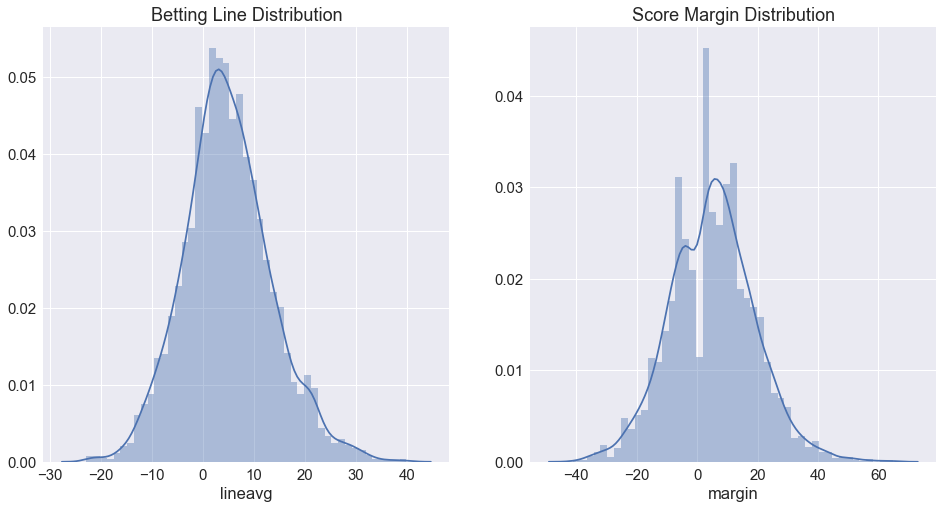

In [31]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax1, ax2 = axes
sns.distplot(odds_2017.lineavg, hist=True, ax=ax1)
sns.distplot(odds_2017.margin, hist=True, ax=ax2)

# odds_2017.lineavg.hist(bins=40)
# odds_2017.margin.hist(bins=40)
# plt.xlabel('Betting Line')
ax1.set_title('Betting Line Distribution')
ax2.set_title('Score Margin Distribution')
line_mean, margin_mean = odds_2017[['lineavg', 'margin']].mean()
line_std, margin_std = odds_2017[['lineavg', 'margin']].std()
print("Mean betting line for home team: {} \nMean margin for home team: {}".format(line_mean, margin_mean))
print("Standard deviation betting line for home team: {} \nStandard deviation result for home team: {}".format(line_std, margin_std))

In [32]:
# Test for Normality
arrs = [odds_2017.lineavg.values, odds_2017.margin.values]
for a in arrs:
    k2, p = normaltest(a)
    alpha = 1e-3
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")


p = 2.86379e-20
The null hypothesis can be rejected
p = 2.18796e-09
The null hypothesis can be rejected


Point spread is normally distributed and on average the home team is favored by ~5 points.

### Plotting Residuals

Text(0.5,1,'Actual Margins and Betting Line Residuals')

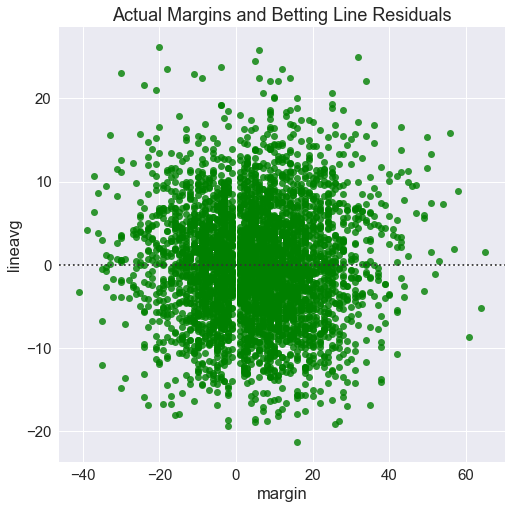

In [33]:
sns.set(font_scale=1.5)
plt.figure(figsize=(8,8))
sns.residplot(data=odds_2017, x='margin', y='lineavg', color='green')
plt.savefig(cwd+"\\Documents\\"+'margin_residuals.png')
plt.title("Actual Margins and Betting Line Residuals")

#### Plotting Betting Lines vs. Actual Results

Text(0.5,1,'Betting Line vs. Actual Results 2017-2018')

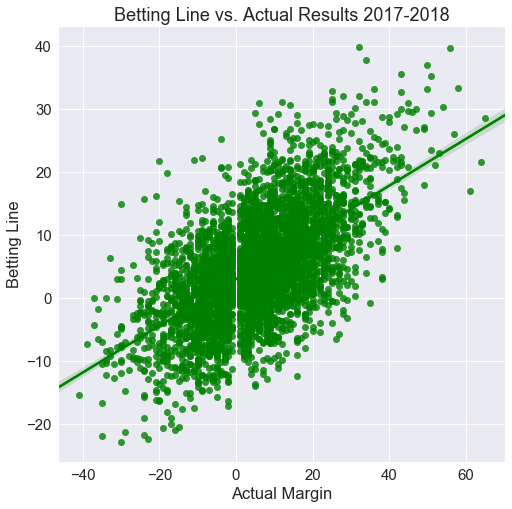

In [34]:
plt.figure(figsize=(8,8))
sns.regplot(data=odds_2017, x='margin', y='lineavg', fit_reg=True, color='green')
plt.xlabel('Actual Margin')
plt.ylabel('Betting Line')
plt.title('Betting Line vs. Actual Results 2017-2018')

### Average Betting Line vs. Actual Results

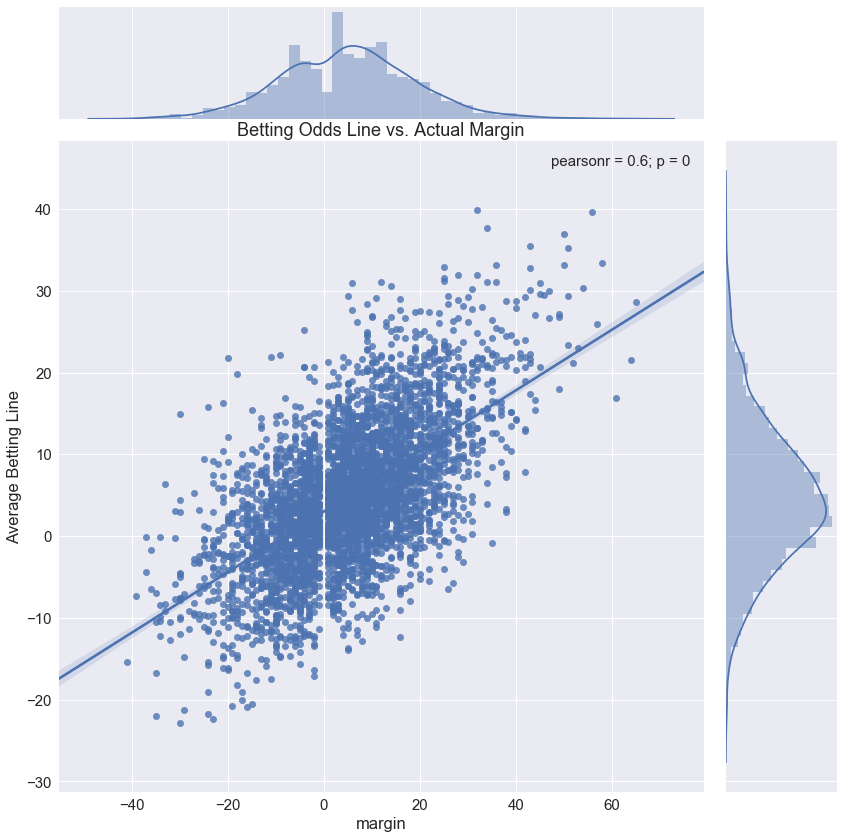

In [35]:
sns.set(font_scale=1.5)

sns.jointplot(data=odds_2017, x='margin', y='lineavg', kind="reg", size=12)
plt.title("Betting Odds Line vs. Actual Margin")
plt.ylabel("Average Betting Line")
plt.savefig(cwd+"\\Documents\\"+'odds_distribution.png')

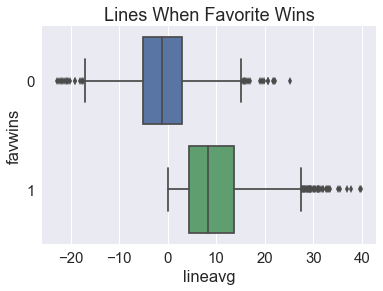

In [36]:
sns.boxplot(data=odds_2017, x='lineavg', y='favwins')
plt.title("Lines When Favorite Wins")
plt.savefig(cwd+"\\Documents\\"+"lines_box.png")

### Cumulative Sum of Beating the Spread vs. Covering the Spread

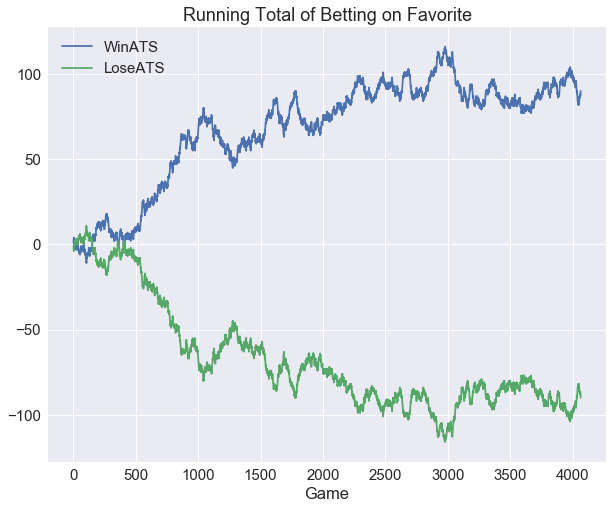

In [37]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 1.5)
x = np.arange(0,len(odds_2017.index.values))
win_ats = np.cumsum(odds_2017['WinATS'])
lose_ats = np.cumsum(odds_2017['LoseATS'])
plt.title("Running Total of Betting on Favorite")
plt.xlabel("Game")
plt.plot(x, win_ats)
plt.plot(x, lose_ats)
plt.legend()
plt.savefig(cwd+"\\Documents\\"+'bets.png')


### Do the same thing with the 2017 and 2018 tourneys

In [38]:
odds_tourney['favwins'] = (odds_tourney[['lineavg', 'margin']]
                        .apply(lambda x: 1 if (x[1] > 0.0) & (x[0] > 0.0) else 0, axis=1)
                       )
odds_tourney.favwins = odds_tourney.favwins.astype('category')
odds_tourney['homewins'] = list(map(lambda x: 1 if x > 0.0 else 0, odds_tourney.margin.values))
odds_tourney.homewins = odds_tourney.homewins.astype('category')
odds_tourney['favoriteID'] = (odds_tourney[['lineavg', 'margin', 'homeID', 'roadID']]
                           .apply(lambda x: x[2] if (x[1] > 0.0) & (x[0] > 0.0) else x[3], axis=1)
                          )
odds_tourney['underdogID'] = (odds_tourney[['lineavg', 'margin', 'homeID', 'roadID']]
                           .apply(lambda x: x[3] if (x[1] > 0.0) & (x[0] > 0.0) else x[2], axis=1)
                          )
odds_tourney['WinATS'] = (odds_tourney[['lineavg', 'margin']]
                                .apply(lambda x: 1 if x[1] > x[0] else -1, axis=1)
                               )
odds_tourney['LoseATS'] = -odds_tourney['WinATS']
odds_tourney.to_csv("Output\\Odds\\tourneyodds_1718.csv")

odds_tourney.tail(10)

,LTeamID,WTeamID,date,home,homeID,hscore,line,lineavg,linedok,linedonc,...,road,roadID,rscore,std,favwins,homewins,favoriteID,underdogID,WinATS,LoseATS
124,1155.0,1242.0,2018-03-23,Kansas,1242,80.0,5.0,3.36,3.86,3.36,...,Clemson,1155.0,76.0,1.71,1,1,1242.0,1155.0,1,-1
125,1345.0,1403.0,2018-03-23,Purdue,1345,65.0,2.0,3.39,1.28,3.60,...,Texas Tech,1403.0,78.0,1.60,0,0,1403.0,1345.0,-1,1
126,1452.0,1437.0,2018-03-23,Villanova,1437,90.0,5.5,5.11,4.04,5.50,...,West Virginia,1452.0,78.0,2.22,1,1,1437.0,1452.0,1,-1
127,1243.0,1260.0,2018-03-24,Kansas St.,1243,62.0,1.0,2.06,1.96,3.60,...,Loyola-Chicago,1260.0,78.0,2.33,0,0,1260.0,1243.0,-1,1
128,1199.0,1276.0,2018-03-24,Michigan,1276,58.0,4.0,4.72,3.39,5.70,...,Florida St.,1199.0,54.0,2.88,1,1,1276.0,1199.0,-1,1
129,1181.0,1242.0,2018-03-25,Kansas,1242,85.0,-3.5,-2.80,-3.95,-2.70,...,Duke,1181.0,81.0,2.04,0,1,1181.0,1242.0,1,-1
130,1403.0,1437.0,2018-03-25,Villanova,1437,71.0,6.5,6.23,5.87,6.40,...,Texas Tech,1403.0,59.0,1.79,1,1,1437.0,1403.0,1,-1
131,1260.0,1276.0,2018-03-31,Michigan,1276,69.0,5.5,6.59,5.95,7.20,...,Loyola-Chicago,1260.0,57.0,2.38,1,1,1276.0,1260.0,1,-1
132,1242.0,1437.0,2018-03-31,Villanova,1437,95.0,5.0,4.60,4.71,4.40,...,Kansas,1242.0,79.0,1.34,1,1,1437.0,1242.0,1,-1
133,1276.0,1437.0,2018-04-02,Villanova,1437,79.0,6.5,4.79,6.13,5.10,...,Michigan,1276.0,62.0,3.30,1,1,1437.0,1276.0,1,-1


In [39]:
odds_tourney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 32 columns):
LTeamID       134 non-null float64
WTeamID       134 non-null float64
date          134 non-null datetime64[ns]
home          134 non-null object
homeID        134 non-null int64
hscore        134 non-null float64
line          134 non-null float64
lineavg       134 non-null float64
linedok       134 non-null float64
linedonc      134 non-null float64
lineespn      134 non-null float64
linefox       134 non-null float64
linemassey    134 non-null float64
linemoore     134 non-null float64
lineopen      134 non-null float64
linepugh      134 non-null float64
linesag       134 non-null float64
linesage      134 non-null float64
linesaggm     134 non-null float64
linesagp      134 non-null float64
margin        134 non-null float64
neutral       134 non-null float64
road          134 non-null object
roadID        134 non-null float64
rscore        134 non-null float64
std           134

In [40]:
print("Favorite win %: ", 100*odds_tourney.favwins.astype(int).sum()/len(odds_tourney))

Favorite win %:  66.4179104478


Mean betting line for home team: 6.845447761194028 
Mean margin for home team: 5.537313432835821
Standard deviation betting line for home team: 6.288076031183331 
Standard deviation result for home team: 12.83126861936201


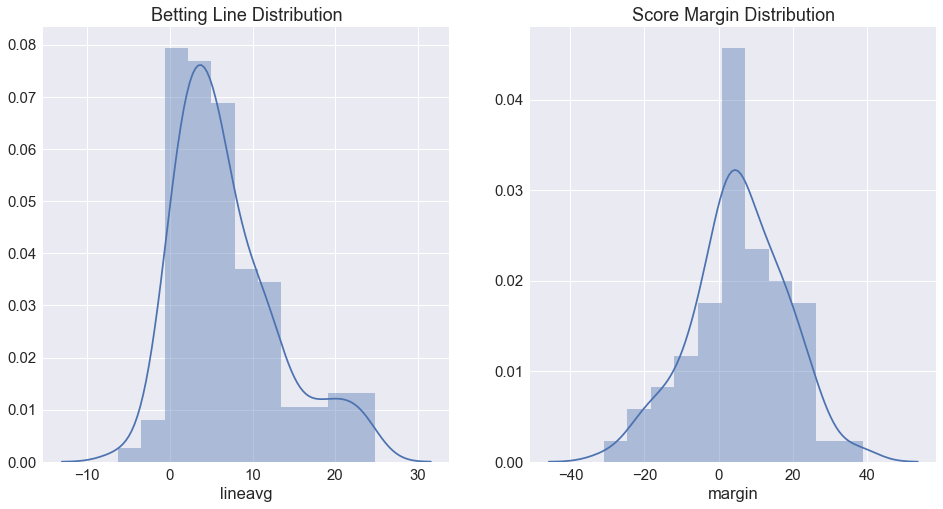

In [41]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax1, ax2 = axes
sns.distplot(odds_tourney.lineavg, hist=True, ax=ax1)
sns.distplot(odds_tourney.margin, hist=True, ax=ax2)

# odds_tourney.lineavg.hist(bins=40)
# odds_tourney.margin.hist(bins=40)
# plt.xlabel('Betting Line')
ax1.set_title('Betting Line Distribution')
ax2.set_title('Score Margin Distribution')
line_mean, margin_mean = odds_tourney[['lineavg', 'margin']].mean()
line_std, margin_std = odds_tourney[['lineavg', 'margin']].std()
print("Mean betting line for home team: {} \nMean margin for home team: {}".format(line_mean, margin_mean))
print("Standard deviation betting line for home team: {} \nStandard deviation result for home team: {}".format(line_std, margin_std))

Text(0.5,1,'Actual Margins and Betting Line Residuals')

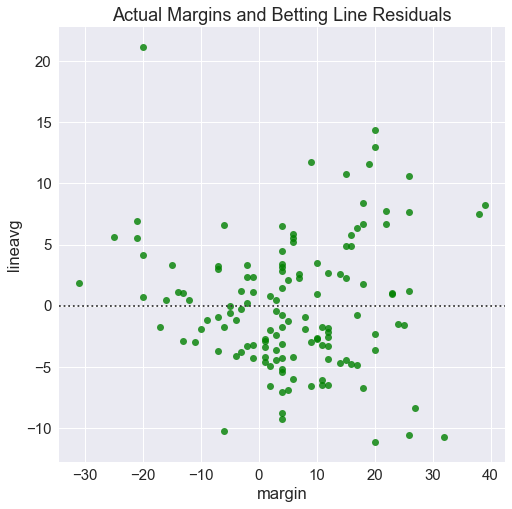

In [42]:
sns.set(font_scale=1.5)
plt.figure(figsize=(8,8))
sns.residplot(data=odds_tourney, x='margin', y='lineavg', color='green')
plt.savefig(cwd+"\\Documents\\"+'margin_residuals_tourney.png')
plt.title("Actual Margins and Betting Line Residuals")

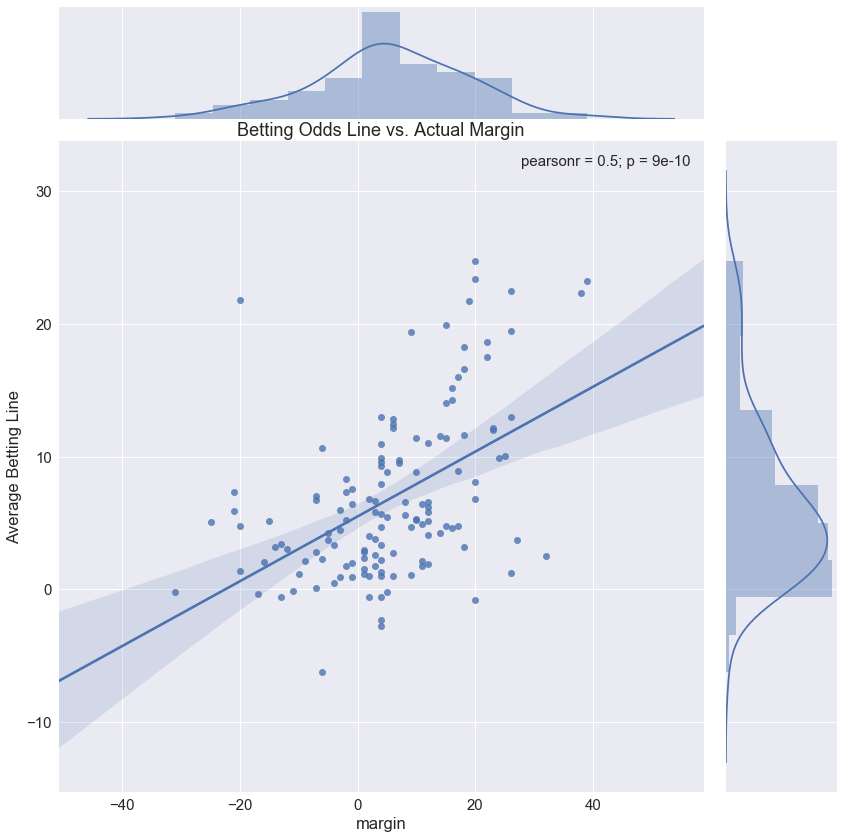

In [43]:
sns.set(font_scale=1.5)

sns.jointplot(data=odds_tourney, x='margin', y='lineavg', kind="reg", size=12)
plt.title("Betting Odds Line vs. Actual Margin")
plt.ylabel("Average Betting Line")
plt.savefig(cwd+"\\Documents\\"+'odds_distribution_tourney.png')

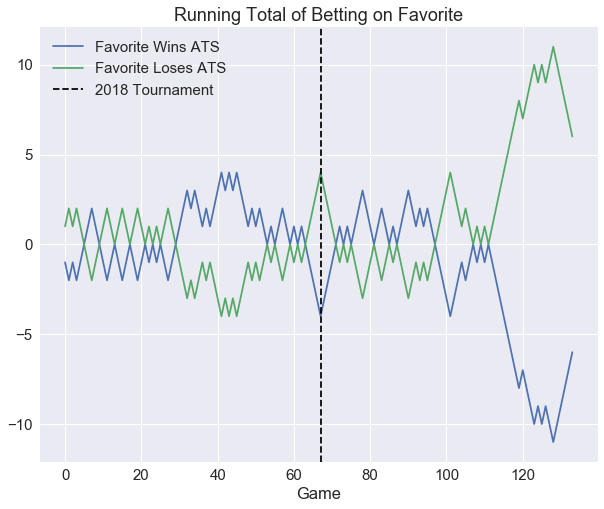

In [44]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 1.5)
x = np.arange(0,len(odds_tourney.index.values))
win_ats = np.cumsum(odds_tourney['WinATS'])
lose_ats = np.cumsum(odds_tourney['LoseATS'])
plt.title("Running Total of Betting on Favorite")
plt.xlabel("Game")
plt.plot(x, win_ats, label="Favorite Wins ATS")
plt.plot(x, lose_ats, label="Favorite Loses ATS")
plt.axvline(67, color='black', linestyle='--', label='2018 Tournament')
plt.legend()
plt.savefig(cwd+"\\Documents\\"+'bets_tourney.png')


#### Distribution of Elo Rankings

In [41]:
K=25
#elos = elo.season_elos(rs_c.reset_index(drop=True), K=K)
elos = pd.read_csv(data_dir+'SeasonElos.csv')
#elos.to_csv(data_dir+"SeasonElosK{}.csv".format(K))
elos.rename({'team_id':'TeamID', 'season_elo':'SeasonElo', 'season':'Season'}, axis=1, inplace=True)
elos.SeasonElo = elos.SeasonElo.astype(float)

In [42]:
elos['Team'] = list(map((lambda x: teams.loc[teams.TeamID==x, 'TeamName'].values[0]), elos['TeamID']))


In [43]:
tourney_teams_by_season = dict(df_stats.groupby('Season')['TeamID'].unique())

In [44]:
tourney_teams_by_season[2018]

array([1437, 1345, 1403, 1455, 1452, 1196, 1116, 1439, 1104, 1139, 1382,
       1417, 1293, 1267, 1372, 1168, 1254, 1347, 1242, 1181, 1277, 1120,
       1155, 1395, 1348, 1371, 1301, 1328, 1113, 1393, 1308, 1158, 1137,
       1233, 1335, 1438, 1153, 1397, 1112, 1246, 1274, 1305, 1166, 1243,
       1400, 1260, 1172, 1138, 1460, 1209, 1420, 1462, 1314, 1276, 1211,
       1326, 1222, 1401, 1281, 1199, 1344, 1361, 1355, 1422, 1285, 1252,
       1300, 1411], dtype=int64)

In [45]:
season=2018
tourney_elos_2018 = elos.loc[(elos.Season==season) & (elos.TeamID.isin(tourney_teams_by_season[season]))].sort_values('SeasonElo', ascending=False)
tourney_elos_2018

,Season,SeasonElo,TeamID,Team
10053,2018,2131.147125,1437,Villanova
10087,2018,2127.413973,1438,Virginia
3301,2018,2067.646521,1211,Gonzaga
2373,2018,2057.680130,1181,Duke
4182,2018,2043.647495,1242,Kansas
6314,2018,2039.485518,1314,North Carolina
321,2018,2035.096586,1112,Arizona
7234,2018,2030.091226,1345,Purdue
4297,2018,2013.839687,1246,Kentucky
5279,2018,2006.320371,1277,Michigan St


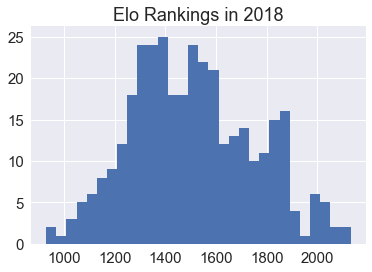

In [46]:
plt.title('Elo Rankings in 2018')
elos.loc[elos.Season==2018, 'SeasonElo'].hist(bins=30)

### Initializing NCAA Tournament DataFrames

In [34]:
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
start = 2003
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
2112,2017,146,1314,75,1246,73,2
2113,2017,146,1376,77,1196,70,7
2114,2017,152,1211,77,1376,73,4
2115,2017,152,1314,77,1332,76,1
2116,2017,154,1314,71,1211,65,6


In [35]:
elos = pd.read_csv(data_dir+'SeasonElos.csv')
elos.rename({'team_id':'TeamID', 'season_elo':'SeasonElo', 'season':'Season'}, axis=1, inplace=True)
elos.head()

,Season,SeasonElo,TeamID
0,2014,1394.749393,1101
1,2015,1278.262520,1101
2,2016,1196.713023,1101
3,2017,1220.408517,1101
4,2018,1271.214779,1101


In [36]:
def winloss_features(df_teams, df_feature, feature_cols, merge_on=['Season'], team_id='TeamID'):
    '''
    Takes input:
    df_teams: a dataframe with columns that specify the winning and losing team, identified by arg team_id
    df_features: a dataframe with features (e.g. stats) that each team has.
    feature_cols: the columns from df_features to extract
    merge_on: the common columns from df_teams and df_features to merge to. Default is 'Season'
    team_id: The name of the column that contains the team identifier for both df_teams and df_features. Default is 'TeamID'.
    Outputs: 
    df_concat: a dataframe containing the original info from df_teams with columns that contain the features for each team
    from df_features
    '''
    
    # Separate teams by win/loss
    w_team_id = 'W'+team_id
    l_team_id = 'L'+team_id
    
    # Prepare columns for feature dataframe
    w_cols = ['W{}'.format(feature) for feature in feature_cols]
    l_cols = ['L{}'.format(feature) for feature in feature_cols]
    diff_cols = ['{}Diff'.format(feature) for feature in feature_cols]
    
    # Create a dict with key = feature, value = Wfeature or Lfeature
    w_dict = dict(zip(feature_cols, w_cols))
    w_dict[team_id] = w_team_id
    
    l_dict = dict(zip(feature_cols, l_cols))
    l_dict[team_id] = l_team_id
    
    df_wins = df_feature.rename(columns=w_dict)
    df_losses = df_feature.rename(columns=l_dict)
    
    # Prepare common columns to merge on
    w_merge_on = merge_on + [w_team_id]
    l_merge_on = merge_on + [l_team_id]
    
    # Merge the dataframes that contain the winning team's features with the losing team's features
    df_dummy = pd.merge(left=df_teams, right=df_wins, how='left', on=w_merge_on)
    df_concat = pd.merge(left=df_dummy, right=df_losses, on=l_merge_on)
    df_concat = df_concat.reindex(columns=list(df_concat.columns)+diff_cols)
    df_concat[diff_cols] = df_concat[w_cols].values - df_concat[l_cols].values
    
    return df_concat



In [37]:
# Extract Elo Rating from winning and losing team
df_tourney_stats = winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'], team_id='TeamID')
df_tourney_stats.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
976,2017,146,1314,75,1246,73,2,2069.157282,2070.780643,-1.623361
977,2017,146,1376,77,1196,70,7,1842.426256,1891.163905,-48.737649
978,2017,152,1211,77,1376,73,4,2029.173847,1842.426256,186.747591
979,2017,152,1314,77,1332,76,1,2069.157282,1948.444923,120.712359
980,2017,154,1314,71,1211,65,6,2069.157282,2029.173847,39.983435


In [41]:
import itertools

def get_schedule(teamID, df_season, teamID_cols=['WTeamID', 'LTeamID']):
    
    teams = (df_season.loc[(df_season.WTeamID==teamID)|(df_season.LTeamID==teamID), teamID_cols]).values
    # flatten list
    teams = list(itertools.chain(*teams))
    
    # remove the current team's ID from list of teams
    teams = list(filter(lambda team: team != teamID, teams))

    return teams

# Build dictionary of season schedules
schedules = dict()
for season in tourney_teams_by_season.keys():
    season_schedule = dict()
    for team in tourney_teams_by_season[season]:
        df_season = rs_c.loc[(rs_c.Season==season)]
        team_schedule = get_schedule(team, df_season)
        season_schedule[team] = team_schedule
    schedules[season] = season_schedule
    

In [42]:
# Calculate average opponent elo ratings
df_stats['AvgOppElo'] = None

for season in schedules.keys():
    for team in schedules[season].keys():
        opps = schedules[season][team]
        opp_elos = [elos.loc[(elos.Season==season) & (elos.TeamID==opp), 'SeasonElo'].values[0] for opp in opps]
        avg_opp_elo = np.mean(opp_elos)
        df_stats.loc[(df_stats.Season==season) & (df_stats.TeamID==team), 'AvgOppElo'] = avg_opp_elo
        
df_stats.tail(16)

,Season,Seed,TeamID,AvgOppElo
1048,2018,2,1314,1809.67
1049,2018,3,1276,1715.99
1050,2018,4,1211,1579.47
1051,2018,5,1326,1716.99
1052,2018,6,1222,1628.78
1053,2018,7,1401,1746.09
1054,2018,8,1281,1735.27
1055,2018,9,1199,1711.1
1056,2018,10,1344,1740.34
1057,2018,11,1361,1602.44
